In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, torchvision 
from PIL import Image

In [3]:
from manipulations import get_Datas
_, Codes, dataset_data_labels, dataset_train_idx, dataset_test_idx = get_Datas([2])

Dataset  2



Done.


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [4]:
from saved_data_io import read_file
data_imgs2 = read_file('data_imgs_dataset2_new')

read from ../saved/data_imgs_dataset2_new.pkl


In [5]:
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# kf = MultilabelStratifiedKFold(5, random_state=0)
# train_idx, test_idx = next(kf.split(Datas, np.array(dataset_data_labels[2])))

In [6]:
len(data_imgs2), len(Codes)

(3453, 3453)

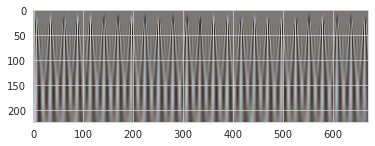

In [7]:
plt.imshow(data_imgs2[5][3])

In [8]:
from manipulations import get_scored_class
from global_vars import labels
n_segments = 11
def crop_imgs(data_img, n_segments = n_segments, vis = False):
    
    shift_len = int((data_img[0].size[0]-224) / (n_segments-1))
    if vis:
        plt.imshow(data_img)
        plt.show()
        
    # each imgs
    imgs = []
    for i in range(n_segments):
        
        # each channel of each segment
        img_chns = []
        for chn in range(4):
            img = data_img[chn].crop((i*shift_len,0,i*shift_len+224,224)) # 0, 0, 224, 224 left, upper, right, and lower
            img_chns.append(img)
            
            if vis:
                plt.imshow(img)
                plt.show()
                
        imgs.append(img_chns)
    return imgs

data_img2_crops = []
data_img2_labels = []
for i in tqdm(range(len(data_imgs2))):
    data_img2_crops += crop_imgs(data_imgs2[i])
    for _ in range(n_segments):
        data_img2_labels.append(get_scored_class(Codes[i], labels))

data_img2_labels = np.array(data_img2_labels)
    

In [9]:
#dataset_train_idx[2n]
train_idx = []
for idx in dataset_train_idx[2]:
    for k in range(n_segments):
        train_idx.append(idx * n_segments + k)
        
test_idx = []
for idx in dataset_test_idx[2]:
    for k in range(n_segments):
        test_idx.append(idx * n_segments + k)

In [10]:
from torch.utils.data import Dataset
from torchvision import transforms
from global_vars import labels
from manipulations import get_name
import os
class MyImageMultichannelDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, channel_imgs, manyhot_encoding_labels, class_idx):
        """
                
        channel_imgs = chn -> array of PImage
        """
        self.manyhot_encoding_labels = manyhot_encoding_labels
        self.channel_imgs = channel_imgs
        self.transform =  transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])

    def __len__(self):
        return len(self.manyhot_encoding_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        images = [self.channel_imgs[idx][chn] for chn in range(4)]
        manyhot_encoding_label = self.manyhot_encoding_labels[idx]
        sample =(torch.cat([self.transform(image) for image in images],0), 
                 torch.Tensor(manyhot_encoding_label[class_idx]))

        return sample

from global_vars import labels, Dx_map, Dx_map_unscored, equivalent_mapping
names = [get_name(label, Dx_map, Dx_map_unscored) for label in labels]
class_idx = np.argwhere(np.sum(np.array(data_img2_labels)[train_idx],axis=0)!=0).flatten() 
names = np.array(names)[class_idx]

print("len(class_idx)", len(class_idx))

image_datasets = MyImageMultichannelDataset(data_img2_crops, data_img2_labels, class_idx)

len(class_idx) 21


In [11]:
imgs0, label0 = image_datasets[0]
label0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.])

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [13]:
from torch import nn
from torchvision import models
    
class MultiCWTNet(nn.Module):
    def __init__(self, n_classes, verbose=False):
        super(MultiCWTNet, self).__init__()
        
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = self.increase_channels(self.resnet.conv1, num_channels=12, copy_weights=0)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, n_classes)

        self.verbose = verbose
        
    def forward(self, xs):
        x = self.resnet(xs)
        return x
    
    
    def increase_channels(self, m, num_channels=None, copy_weights=0):
        """
        https://github.com/akashpalrecha/Resnet-multichannel/blob/master/multichannel_resnet.py
        
        takes as input a Conv2d layer and returns the a Conv2d layer with `num_channels` input channels
        
        copy_weights (int): copy the weights of the channel (int)
        """
        # number of input channels the new module should have
        new_in_channels = num_channels if num_channels is not None else m.in_channels + 1
        
        # Creating new Conv2d layer
        new_m = nn.Conv2d(in_channels=new_in_channels, 
                          out_channels=m.out_channels, 
                          kernel_size=m.kernel_size, 
                          stride=m.stride, 
                          padding=m.padding,
                          bias=False)
        
        # Copying the weights from the old to the new layer
        new_m.weight[:, :m.in_channels, :, :] = m.weight.clone()
        
        #Copying the weights of the `copy_weights` channel of the old layer to the extra channels of the new layer
        for i in range(new_in_channels - m.in_channels): # 12 - 3
            channel = m.in_channels + i # 3，4，5，6，7，8，9，10，11
            new_m.weight[:, channel:channel+1, :, :] = m.weight[:, copy_weights:copy_weights+1, : :].clone()
        new_m.weight = nn.Parameter(new_m.weight)

        return new_m

In [17]:
len(trainDataset)

30382

In [ ]:
from torchvision import datasets, models, transforms

from myeval import agg_y_preds_bags, binary_acc, geometry_loss, compute_score
import torch.optim as optim
from torch.optim import lr_scheduler
from snippets.pytorchtools import EarlyStopping
import time
from pytorch_training import add_pr_curve_tensorboard
from imbalanced_sampler import  WeightedImbalancedDatasetSampler
from torch.utils.tensorboard import SummaryWriter

st = time.time()
patience = 50
batch_size= 64#65000
from global_vars import normal_class
normal_idx = np.argwhere(names==int(normal_class))
run_name = 'modelMultiCWTFull_dataset2_sampler'
writer = SummaryWriter('runs/{}'.format(run_name))

from global_vars import weights


from imbalanced_weights import cal_multilabel_weights, inverse_weight
sample_weights, Data_labels_train_new, label_to_count, new_index_dict = cal_multilabel_weights(data_img2_labels[train_idx], 0)


trainDataset = torch.utils.data.Subset(image_datasets, train_idx)
testDataset = torch.utils.data.Subset(image_datasets, test_idx)

trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, pin_memory=True, 
                                          sampler=WeightedImbalancedDatasetSampler(trainDataset, weights=sample_weights))
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=300, shuffle = False, pin_memory=True)

#train_class_weight = torch.Tensor(inverse_weight(Data_labels_train, class_idx)).to(device)
#test_class_weight = torch.Tensor(inverse_weight(Data_labels_test, class_idx)).to(device)
criterion_train = nn.BCEWithLogitsLoss(reduction='mean')#, weight=train_class_weight) 
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')#, weight=test_class_weight) 

saved_dir = '../saved/modelMultiCWTFull2/'
early_stopping = EarlyStopping(patience, verbose=False, 
                              saved_dir=saved_dir, 
                              save_name=run_name)

model = MultiCWTNet(len(class_idx), verbose=False)
model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.01) 
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #
# Decay LR by a factor of 0.1 every 100 epochs
#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=20, mode='max')


y_trains_tensor = None
y_tests_tensor = None
losses_train = []
avg_losses_train = []
losses_test = []
avg_losses_test = []

for epoch in range(0, 5000):

    model.train()

    running_loss_train = 0.0

    y_trains = [] # ground truth
    output_trains = [] # output
    for k, (X_train, y_train) in tqdm(enumerate(trainLoader)):
        y_train = y_train.to(device)
        X_train = X_train.to(device)
        optimizer.zero_grad()
        output_train = model(X_train)
        output_trains.append(output_train.cpu())
        
        loss_train = criterion_train(output_train, y_train)
        losses_train.append(loss_train.item())
        
        avg_loss_train = np.average(losses_train)
        avg_losses_train.append(avg_loss_train)
    
        
        if np.mod(k, 100) == 0:
            writer.add_scalar('train/loss',
            avg_loss_train,
            epoch * (len(train_idx)//batch_size//100+1) + k//100)
        
        y_trains.append(y_train.cpu())
            
        loss_train.backward()
        optimizer.step()
            
    #scheduler.step()
    

    y_tests = [] # ground truth
    output_tests = [] # output
    with torch.no_grad():
        model.eval()
        
        for X_test, y_test in testLoader:  
            y_test = y_test.to(device)
            X_test = X_test.to(device)
            output_test = model(X_test)

            loss_test = criterion_test(output_test, y_test)
            losses_test.append(loss_test.item())

            output_tests.append(output_test.cpu())
            y_tests.append(y_test.cpu())
            
            
            
        avg_loss_test = np.average(losses_test)
        avg_losses_test.append(avg_loss_test)

        writer.add_scalar('test/loss',
                avg_loss_test,
                epoch)



    y_trains_tensor = torch.cat(y_trains, axis=0) # ground truth
    y_tests_tensor = torch.cat(y_tests, axis=0) # ground truth

    output_trains = torch.cat(output_trains, axis=0) 
    y_train_preds = torch.sigmoid(output_trains)

    output_tests = torch.cat(output_tests, axis=0)
    y_test_preds = torch.sigmoid(output_tests)

    #output_trains = torch.cat(output_trains, axis=0)
#     y_train_preds_max, y_train_preds_mean, _ = agg_y_preds_bags(y_train_preds, bag_size=n_segments)
#     y_test_preds_max, y_test_preds_mean, _ = agg_y_preds_bags(y_test_preds, bag_size=n_segments)
#     _, _, y_trains = agg_y_preds_bags(y_trains, bag_size=n_segments)
#     _, _, y_tests = agg_y_preds_bags(y_tests, bag_size=n_segments)


    for class_i_idx in range(len(class_idx)):
        add_pr_curve_tensorboard(writer, class_i_idx, y_trains_tensor, y_train_preds, names, global_step=epoch, prefix='train/')
        add_pr_curve_tensorboard(writer, class_i_idx, y_tests_tensor, y_test_preds, names, global_step=epoch, prefix='test/')



    acc, fmeasure, fbeta, gbeta = binary_acc(y_train_preds, y_trains_tensor)           
    acc2, fmeasure2, fbeta2, gbeta2 = binary_acc(y_test_preds, y_tests_tensor)
    geometry = geometry_loss(fbeta, gbeta)
    geometry2 = geometry_loss(fbeta2, gbeta2)
    
#     output_str = 'S{} {:.2f} min |\n Train Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f} |\n Valid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f}\n '.format(
#         epoch, (time.time()-st)/60,
#         avg_loss_train, acc, fmeasure, fbeta, gbeta, geometry, np.nan,
#         avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, geometry2, np.nan)
#     print(output_str)
    score = compute_score(np.round(y_train_preds.data.numpy()), np.round(y_trains_tensor.data.numpy()),  weights, class_idx, normal_idx)
    score2 = compute_score(np.round(y_test_preds.data.numpy()), np.round(y_tests_tensor.data.numpy()), weights, class_idx, normal_idx)
    output_str = 'S{} {:.2f} min |\n Train Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f} |\n Valid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f}\n '.format(
        epoch, (time.time()-st)/60,
        avg_loss_train, acc, fmeasure, fbeta, gbeta, geometry, score,
        avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, geometry2, score2)
    scheduler.step(score2)
    
    writer.add_scalar('train/score',
            score,
            epoch)

    writer.add_scalar('test/score',
            score2,
            epoch)
    
    print(output_str)

    with open(saved_dir+'loss_{}.txt'.format(run_name), 'a') as f:
        print(output_str, file=f)

    early_stopping(-score2, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


#     output_string = 'AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure|Geomotry\n{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}'.format(auroc2,auprc2,acc2,fmeasure2,fbeta2,gbeta2,geometry2)
#     print(output_string)     
#     with open(saved_dir+'score'+ str(i)+ '_epoch' + str(epoch) + '.txt', 'w') as f:
#         f.write(output_string)

#     avg_losses_train = np.array(avg_losses_train)
#     avg_losses_test = np.array(avg_losses_test)

#     np.save(saved_dir + 'avg_losses_train' + str(i) + '_epoch' + str(epoch), avg_losses_train)
#     np.save(saved_dir + 'avg_losses_test' + str(i) + '_epoch' + str(epoch), avg_losses_test)


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()



S1 3.74 min |
 Train Loss: 0.228755, Acc: 0.919, F: 0.231, Fbeta: 0.294, gbeta: 0.116, geo: 0.185, score: 0.843 |
 Valid Loss: 0.175902, Acc: 0.948, F: 0.181, Fbeta: 0.153, gbeta: 0.103, geo: 0.126, score: 0.256
 



S2 7.53 min |
 Train Loss: 0.143138, Acc: 0.980, F: 0.875, Fbeta: 0.893, gbeta: 0.726, geo: 0.805, score: 0.939 |
 Valid Loss: 0.174954, Acc: 0.951, F: 0.187, Fbeta: 0.159, gbeta: 0.108, geo: 0.131, score: 0.293
 



S3 11.25 min |
 Train Loss: 0.103863, Acc: 0.991, F: 0.956, Fbeta: 0.959, gbeta: 0.887, geo: 0.922, score: 0.969 |
 Valid Loss: 0.168098, Acc: 0.958, F: 0.201, Fbeta: 0.183, gbeta: 0.115, geo: 0.145, score: 0.321
 



S4 14.99 min |
 Train Loss: 0.082192, Acc: 0.994, F: 0.972, Fbeta: 0.973, gbeta: 0.924, geo: 0.948, score: 0.977 |
 Valid Loss: 0.166664, Acc: 0.955, F: 0.252, Fbeta: 0.233, gbeta: 0.167, geo: 0.197, score: 0.299
 



S5 18.73 min |
 Train Loss: 0.068542, Acc: 0.995, F: 0.975, Fbeta: 0.976, gbeta: 0.935, geo: 0.955, score: 0.981 |
 Valid Loss: 0.168992, Acc: 0.960, F: 0.189, Fbeta: 0.172, gbeta: 0.110, geo: 0.137, score: 0.311
 



S6 22.47 min |
 Train Loss: 0.058818, Acc: 0.996, F: 0.982, Fbeta: 0.982, gbeta: 0.951, geo: 0.966, score: 0.985 |
 Valid Loss: 0.169566, Acc: 0.964, F: 0.191, Fbeta: 0.186, gbeta: 0.114, geo: 0.146, score: 0.345
 



S7 26.18 min |
 Train Loss: 0.051704, Acc: 0.997, F: 0.983, Fbeta: 0.984, gbeta: 0.956, geo: 0.970, score: 0.988 |
 Valid Loss: 0.169191, Acc: 0.966, F: 0.217, Fbeta: 0.202, gbeta: 0.132, geo: 0.163, score: 0.389
 



S8 30.02 min |
 Train Loss: 0.046366, Acc: 0.997, F: 0.984, Fbeta: 0.984, gbeta: 0.958, geo: 0.971, score: 0.985 |
 Valid Loss: 0.168789, Acc: 0.965, F: 0.252, Fbeta: 0.248, gbeta: 0.173, geo: 0.207, score: 0.383
 



S9 33.77 min |
 Train Loss: 0.042106, Acc: 0.997, F: 0.986, Fbeta: 0.986, gbeta: 0.961, geo: 0.973, score: 0.988 |
 Valid Loss: 0.168688, Acc: 0.962, F: 0.177, Fbeta: 0.155, gbeta: 0.082, geo: 0.113, score: 0.349
 



S10 37.50 min |
 Train Loss: 0.038493, Acc: 0.998, F: 0.989, Fbeta: 0.989, gbeta: 0.970, geo: 0.979, score: 0.990 |
 Valid Loss: 0.169314, Acc: 0.971, F: 0.257, Fbeta: 0.250, gbeta: 0.176, geo: 0.210, score: 0.434
 



S11 41.19 min |
 Train Loss: 0.035691, Acc: 0.997, F: 0.986, Fbeta: 0.986, gbeta: 0.962, geo: 0.974, score: 0.988 |
 Valid Loss: 0.171466, Acc: 0.961, F: 0.209, Fbeta: 0.191, gbeta: 0.123, geo: 0.153, score: 0.334
 



S12 44.88 min |
 Train Loss: 0.033260, Acc: 0.997, F: 0.987, Fbeta: 0.987, gbeta: 0.965, geo: 0.976, score: 0.989 |
 Valid Loss: 0.173047, Acc: 0.960, F: 0.196, Fbeta: 0.187, gbeta: 0.119, geo: 0.149, score: 0.323
 



S13 48.82 min |
 Train Loss: 0.031139, Acc: 0.998, F: 0.989, Fbeta: 0.989, gbeta: 0.970, geo: 0.979, score: 0.990 |
 Valid Loss: 0.173974, Acc: 0.963, F: 0.271, Fbeta: 0.261, gbeta: 0.179, geo: 0.216, score: 0.361
 



S14 52.57 min |
 Train Loss: 0.029292, Acc: 0.998, F: 0.990, Fbeta: 0.989, gbeta: 0.971, geo: 0.980, score: 0.990 |
 Valid Loss: 0.174601, Acc: 0.969, F: 0.248, Fbeta: 0.243, gbeta: 0.170, geo: 0.204, score: 0.405
 



S15 56.23 min |
 Train Loss: 0.027629, Acc: 0.998, F: 0.991, Fbeta: 0.990, gbeta: 0.975, geo: 0.983, score: 0.992 |
 Valid Loss: 0.177664, Acc: 0.959, F: 0.216, Fbeta: 0.188, gbeta: 0.124, geo: 0.153, score: 0.336
 



S16 59.89 min |
 Train Loss: 0.026205, Acc: 0.998, F: 0.990, Fbeta: 0.990, gbeta: 0.974, geo: 0.982, score: 0.992 |
 Valid Loss: 0.177311, Acc: 0.970, F: 0.235, Fbeta: 0.226, gbeta: 0.143, geo: 0.180, score: 0.434
 



S17 63.56 min |
 Train Loss: 0.024992, Acc: 0.998, F: 0.990, Fbeta: 0.989, gbeta: 0.971, geo: 0.980, score: 0.990 |
 Valid Loss: 0.176766, Acc: 0.969, F: 0.274, Fbeta: 0.264, gbeta: 0.187, geo: 0.222, score: 0.420
 



S18 67.25 min |
 Train Loss: 0.023821, Acc: 0.998, F: 0.991, Fbeta: 0.991, gbeta: 0.976, geo: 0.983, score: 0.992 |
 Valid Loss: 0.176754, Acc: 0.970, F: 0.220, Fbeta: 0.209, gbeta: 0.135, geo: 0.168, score: 0.423
 



S19 70.94 min |
 Train Loss: 0.022834, Acc: 0.998, F: 0.990, Fbeta: 0.989, gbeta: 0.973, geo: 0.981, score: 0.991 |
 Valid Loss: 0.176159, Acc: 0.972, F: 0.215, Fbeta: 0.209, gbeta: 0.132, geo: 0.166, score: 0.457
 



S20 74.74 min |
 Train Loss: 0.021888, Acc: 0.998, F: 0.991, Fbeta: 0.991, gbeta: 0.977, geo: 0.984, score: 0.993 |
 Valid Loss: 0.176717, Acc: 0.967, F: 0.161, Fbeta: 0.149, gbeta: 0.078, geo: 0.108, score: 0.391
 



S21 78.71 min |
 Train Loss: 0.021042, Acc: 0.998, F: 0.990, Fbeta: 0.990, gbeta: 0.975, geo: 0.982, score: 0.992 |
 Valid Loss: 0.176914, Acc: 0.969, F: 0.166, Fbeta: 0.157, gbeta: 0.085, geo: 0.116, score: 0.408
 



S22 82.54 min |
 Train Loss: 0.020255, Acc: 0.998, F: 0.991, Fbeta: 0.991, gbeta: 0.976, geo: 0.984, score: 0.993 |
 Valid Loss: 0.176617, Acc: 0.972, F: 0.241, Fbeta: 0.236, gbeta: 0.146, geo: 0.186, score: 0.457
 



S23 86.40 min |
 Train Loss: 0.019561, Acc: 0.998, F: 0.991, Fbeta: 0.990, gbeta: 0.975, geo: 0.983, score: 0.992 |
 Valid Loss: 0.176595, Acc: 0.972, F: 0.263, Fbeta: 0.262, gbeta: 0.182, geo: 0.218, score: 0.445
 



S24 90.22 min |
 Train Loss: 0.018884, Acc: 0.999, F: 0.992, Fbeta: 0.991, gbeta: 0.978, geo: 0.985, score: 0.994 |
 Valid Loss: 0.177257, Acc: 0.969, F: 0.210, Fbeta: 0.212, gbeta: 0.131, geo: 0.167, score: 0.411
 



S25 94.16 min |
 Train Loss: 0.018324, Acc: 0.998, F: 0.991, Fbeta: 0.990, gbeta: 0.973, geo: 0.981, score: 0.991 |
 Valid Loss: 0.177508, Acc: 0.969, F: 0.238, Fbeta: 0.227, gbeta: 0.144, geo: 0.180, score: 0.422
 



S26 97.94 min |
 Train Loss: 0.017732, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.986, score: 0.994 |
 Valid Loss: 0.177901, Acc: 0.973, F: 0.256, Fbeta: 0.258, gbeta: 0.179, geo: 0.215, score: 0.482
 



S27 101.70 min |
 Train Loss: 0.017202, Acc: 0.999, F: 0.992, Fbeta: 0.992, gbeta: 0.980, geo: 0.986, score: 0.994 |
 Valid Loss: 0.177573, Acc: 0.974, F: 0.288, Fbeta: 0.280, gbeta: 0.198, geo: 0.236, score: 0.488
 



S28 105.45 min |
 Train Loss: 0.016702, Acc: 0.999, F: 0.992, Fbeta: 0.991, gbeta: 0.979, geo: 0.985, score: 0.993 |
 Valid Loss: 0.177815, Acc: 0.973, F: 0.201, Fbeta: 0.197, gbeta: 0.127, geo: 0.158, score: 0.469
 



S29 109.27 min |
 Train Loss: 0.016276, Acc: 0.998, F: 0.991, Fbeta: 0.990, gbeta: 0.975, geo: 0.983, score: 0.993 |
 Valid Loss: 0.177378, Acc: 0.971, F: 0.275, Fbeta: 0.263, gbeta: 0.186, geo: 0.221, score: 0.434
 



S30 113.22 min |
 Train Loss: 0.015832, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.986, score: 0.993 |
 Valid Loss: 0.177527, Acc: 0.972, F: 0.257, Fbeta: 0.261, gbeta: 0.179, geo: 0.216, score: 0.457
 



S31 117.04 min |
 Train Loss: 0.015419, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.986, score: 0.994 |
 Valid Loss: 0.178005, Acc: 0.974, F: 0.243, Fbeta: 0.235, gbeta: 0.149, geo: 0.187, score: 0.506
 



S32 120.89 min |
 Train Loss: 0.015031, Acc: 0.999, F: 0.992, Fbeta: 0.992, gbeta: 0.979, geo: 0.986, score: 0.994 |
 Valid Loss: 0.178518, Acc: 0.972, F: 0.195, Fbeta: 0.179, gbeta: 0.099, geo: 0.133, score: 0.454
 



S33 124.71 min |
 Train Loss: 0.014669, Acc: 0.999, F: 0.992, Fbeta: 0.991, gbeta: 0.979, geo: 0.985, score: 0.994 |
 Valid Loss: 0.179084, Acc: 0.973, F: 0.224, Fbeta: 0.213, gbeta: 0.139, geo: 0.172, score: 0.481
 



S34 128.49 min |
 Train Loss: 0.014330, Acc: 0.999, F: 0.992, Fbeta: 0.992, gbeta: 0.980, geo: 0.986, score: 0.994 |
 Valid Loss: 0.179549, Acc: 0.970, F: 0.265, Fbeta: 0.255, gbeta: 0.180, geo: 0.214, score: 0.434
 



S35 132.24 min |
 Train Loss: 0.014005, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.980, geo: 0.986, score: 0.994 |
 Valid Loss: 0.179986, Acc: 0.972, F: 0.269, Fbeta: 0.257, gbeta: 0.180, geo: 0.215, score: 0.451
 



S36 135.94 min |
 Train Loss: 0.013698, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.982, geo: 0.987, score: 0.994 |
 Valid Loss: 0.180528, Acc: 0.972, F: 0.214, Fbeta: 0.207, gbeta: 0.132, geo: 0.166, score: 0.460
 



S37 139.67 min |
 Train Loss: 0.013409, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.987, score: 0.994 |
 Valid Loss: 0.181240, Acc: 0.970, F: 0.280, Fbeta: 0.268, gbeta: 0.187, geo: 0.224, score: 0.424
 



S38 143.37 min |
 Train Loss: 0.013131, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.987, score: 0.994 |
 Valid Loss: 0.182277, Acc: 0.972, F: 0.208, Fbeta: 0.196, gbeta: 0.128, geo: 0.158, score: 0.445
 



S39 147.24 min |
 Train Loss: 0.012878, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.986, score: 0.993 |
 Valid Loss: 0.182287, Acc: 0.973, F: 0.206, Fbeta: 0.204, gbeta: 0.127, geo: 0.161, score: 0.465
 



S40 151.29 min |
 Train Loss: 0.012617, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.995 |
 Valid Loss: 0.182714, Acc: 0.974, F: 0.255, Fbeta: 0.255, gbeta: 0.176, geo: 0.211, score: 0.476
 



S41 155.29 min |
 Train Loss: 0.012404, Acc: 0.999, F: 0.992, Fbeta: 0.991, gbeta: 0.978, geo: 0.985, score: 0.993 |
 Valid Loss: 0.182770, Acc: 0.975, F: 0.276, Fbeta: 0.275, gbeta: 0.190, geo: 0.229, score: 0.515
 



S42 159.09 min |
 Train Loss: 0.012156, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.984, geo: 0.989, score: 0.996 |
 Valid Loss: 0.183274, Acc: 0.976, F: 0.210, Fbeta: 0.212, gbeta: 0.132, geo: 0.168, score: 0.521
 



S43 162.92 min |
 Train Loss: 0.011927, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.994 |
 Valid Loss: 0.183707, Acc: 0.974, F: 0.252, Fbeta: 0.252, gbeta: 0.175, geo: 0.210, score: 0.493
 



S44 166.88 min |
 Train Loss: 0.011719, Acc: 0.999, F: 0.992, Fbeta: 0.992, gbeta: 0.980, geo: 0.986, score: 0.994 |
 Valid Loss: 0.184184, Acc: 0.974, F: 0.269, Fbeta: 0.268, gbeta: 0.185, geo: 0.223, score: 0.482
 



S45 170.76 min |
 Train Loss: 0.011519, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.994 |
 Valid Loss: 0.184744, Acc: 0.975, F: 0.246, Fbeta: 0.249, gbeta: 0.173, geo: 0.208, score: 0.504
 



S46 174.65 min |
 Train Loss: 0.011325, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.994 |
 Valid Loss: 0.185500, Acc: 0.968, F: 0.205, Fbeta: 0.202, gbeta: 0.125, geo: 0.159, score: 0.410
 



S47 178.51 min |
 Train Loss: 0.011140, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.994 |
 Valid Loss: 0.185777, Acc: 0.975, F: 0.276, Fbeta: 0.271, gbeta: 0.189, geo: 0.227, score: 0.497
 



S48 182.38 min |
 Train Loss: 0.010970, Acc: 0.999, F: 0.994, Fbeta: 0.992, gbeta: 0.982, geo: 0.987, score: 0.993 |
 Valid Loss: 0.186113, Acc: 0.973, F: 0.282, Fbeta: 0.280, gbeta: 0.192, geo: 0.232, score: 0.478
 



S49 186.23 min |
 Train Loss: 0.010799, Acc: 0.999, F: 0.992, Fbeta: 0.992, gbeta: 0.981, geo: 0.987, score: 0.996 |
 Valid Loss: 0.186060, Acc: 0.976, F: 0.251, Fbeta: 0.254, gbeta: 0.178, geo: 0.213, score: 0.518
 



S50 190.09 min |
 Train Loss: 0.010633, Acc: 0.999, F: 0.993, Fbeta: 0.993, gbeta: 0.982, geo: 0.988, score: 0.995 |
 Valid Loss: 0.186308, Acc: 0.973, F: 0.259, Fbeta: 0.256, gbeta: 0.179, geo: 0.214, score: 0.480
 



S51 194.13 min |
 Train Loss: 0.010473, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.994 |
 Valid Loss: 0.186731, Acc: 0.976, F: 0.254, Fbeta: 0.258, gbeta: 0.175, geo: 0.213, score: 0.534
 



S52 198.06 min |
 Train Loss: 0.010320, Acc: 0.999, F: 0.994, Fbeta: 0.992, gbeta: 0.983, geo: 0.987, score: 0.994 |
 Valid Loss: 0.186827, Acc: 0.976, F: 0.249, Fbeta: 0.256, gbeta: 0.175, geo: 0.211, score: 0.543
 



S53 202.06 min |
 Train Loss: 0.010169, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.984, geo: 0.988, score: 0.995 |
 Valid Loss: 0.187171, Acc: 0.974, F: 0.223, Fbeta: 0.218, gbeta: 0.137, geo: 0.173, score: 0.478
 



S54 205.92 min |
 Train Loss: 0.010026, Acc: 0.999, F: 0.992, Fbeta: 0.993, gbeta: 0.981, geo: 0.987, score: 0.996 |
 Valid Loss: 0.187394, Acc: 0.974, F: 0.272, Fbeta: 0.267, gbeta: 0.184, geo: 0.222, score: 0.484
 



S55 209.78 min |
 Train Loss: 0.009889, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.984, geo: 0.988, score: 0.994 |
 Valid Loss: 0.187830, Acc: 0.975, F: 0.203, Fbeta: 0.205, gbeta: 0.128, geo: 0.162, score: 0.494
 



S56 213.62 min |
 Train Loss: 0.009767, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.986, score: 0.993 |
 Valid Loss: 0.188076, Acc: 0.975, F: 0.265, Fbeta: 0.262, gbeta: 0.181, geo: 0.218, score: 0.493
 



S57 217.48 min |
 Train Loss: 0.009634, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.995 |
 Valid Loss: 0.188315, Acc: 0.977, F: 0.243, Fbeta: 0.242, gbeta: 0.150, geo: 0.190, score: 0.532
 



S58 221.36 min |
 Train Loss: 0.009514, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.994 |
 Valid Loss: 0.188808, Acc: 0.974, F: 0.261, Fbeta: 0.256, gbeta: 0.180, geo: 0.215, score: 0.491
 



S59 225.22 min |
 Train Loss: 0.009392, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.987, score: 0.995 |
 Valid Loss: 0.189556, Acc: 0.975, F: 0.252, Fbeta: 0.254, gbeta: 0.177, geo: 0.212, score: 0.519
 



S60 229.13 min |
 Train Loss: 0.009279, Acc: 0.999, F: 0.993, Fbeta: 0.993, gbeta: 0.982, geo: 0.987, score: 0.995 |
 Valid Loss: 0.190186, Acc: 0.973, F: 0.266, Fbeta: 0.258, gbeta: 0.179, geo: 0.215, score: 0.457
 



S61 233.08 min |
 Train Loss: 0.009173, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.987, score: 0.994 |
 Valid Loss: 0.190722, Acc: 0.972, F: 0.256, Fbeta: 0.252, gbeta: 0.176, geo: 0.211, score: 0.456
 



S62 236.94 min |
 Train Loss: 0.009064, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.994 |
 Valid Loss: 0.191189, Acc: 0.976, F: 0.245, Fbeta: 0.249, gbeta: 0.173, geo: 0.208, score: 0.520
 



S63 240.81 min |
 Train Loss: 0.008952, Acc: 0.999, F: 0.995, Fbeta: 0.994, gbeta: 0.985, geo: 0.989, score: 0.995 |
 Valid Loss: 0.191894, Acc: 0.975, F: 0.267, Fbeta: 0.257, gbeta: 0.182, geo: 0.216, score: 0.500
 



S64 244.80 min |
 Train Loss: 0.008851, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.994 |
 Valid Loss: 0.192349, Acc: 0.972, F: 0.265, Fbeta: 0.255, gbeta: 0.181, geo: 0.215, score: 0.463
 



S65 248.70 min |
 Train Loss: 0.008749, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.984, geo: 0.989, score: 0.995 |
 Valid Loss: 0.192559, Acc: 0.974, F: 0.211, Fbeta: 0.207, gbeta: 0.130, geo: 0.164, score: 0.491
 



S66 252.63 min |
 Train Loss: 0.008650, Acc: 0.999, F: 0.993, Fbeta: 0.993, gbeta: 0.982, geo: 0.988, score: 0.996 |
 Valid Loss: 0.193284, Acc: 0.976, F: 0.256, Fbeta: 0.258, gbeta: 0.179, geo: 0.215, score: 0.527
 



S67 256.50 min |
 Train Loss: 0.008556, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.983, geo: 0.988, score: 0.995 |
 Valid Loss: 0.193967, Acc: 0.974, F: 0.279, Fbeta: 0.275, gbeta: 0.189, geo: 0.228, score: 0.482
 



S68 260.37 min |
 Train Loss: 0.008460, Acc: 0.999, F: 0.995, Fbeta: 0.994, gbeta: 0.985, geo: 0.989, score: 0.995 |
 Valid Loss: 0.194752, Acc: 0.975, F: 0.266, Fbeta: 0.266, gbeta: 0.182, geo: 0.220, score: 0.495
 



S69 264.23 min |
 Train Loss: 0.008376, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.982, geo: 0.987, score: 0.994 |
 Valid Loss: 0.195338, Acc: 0.973, F: 0.216, Fbeta: 0.213, gbeta: 0.137, geo: 0.171, score: 0.462
 



S70 268.27 min |
 Train Loss: 0.008284, Acc: 0.999, F: 0.994, Fbeta: 0.994, gbeta: 0.985, geo: 0.989, score: 0.995 |
 Valid Loss: 0.195964, Acc: 0.975, F: 0.253, Fbeta: 0.255, gbeta: 0.175, geo: 0.211, score: 0.507
 



S71 272.27 min |
 Train Loss: 0.008198, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.984, geo: 0.988, score: 0.995 |
 Valid Loss: 0.196428, Acc: 0.974, F: 0.257, Fbeta: 0.257, gbeta: 0.178, geo: 0.214, score: 0.487
 



S72 276.08 min |
 Train Loss: 0.008114, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.984, geo: 0.989, score: 0.995 |
 Valid Loss: 0.196911, Acc: 0.972, F: 0.256, Fbeta: 0.260, gbeta: 0.177, geo: 0.214, score: 0.460
 



S73 279.93 min |
 Train Loss: 0.008044, Acc: 0.999, F: 0.993, Fbeta: 0.992, gbeta: 0.981, geo: 0.986, score: 0.994 |
 Valid Loss: 0.197608, Acc: 0.974, F: 0.265, Fbeta: 0.261, gbeta: 0.183, geo: 0.219, score: 0.485
 



S74 283.71 min |
 Train Loss: 0.007959, Acc: 0.999, F: 0.994, Fbeta: 0.993, gbeta: 0.984, geo: 0.989, score: 0.996 |
 Valid Loss: 0.198102, Acc: 0.977, F: 0.273, Fbeta: 0.276, gbeta: 0.188, geo: 0.228, score: 0.550
 



S75 287.37 min |
 Train Loss: 0.007877, Acc: 0.999, F: 0.992, Fbeta: 0.994, gbeta: 0.983, geo: 0.988, score: 0.998 |
 Valid Loss: 0.198533, Acc: 0.977, F: 0.257, Fbeta: 0.263, gbeta: 0.179, geo: 0.217, score: 0.553
 



S76 291.88 min |
 Train Loss: 0.007794, Acc: 0.999, F: 0.995, Fbeta: 0.994, gbeta: 0.986, geo: 0.990, score: 0.995 |
 Valid Loss: 0.198925, Acc: 0.978, F: 0.262, Fbeta: 0.269, gbeta: 0.183, geo: 0.222, score: 0.584
 



S77 296.63 min |
 Train Loss: 0.007714, Acc: 0.999, F: 0.994, Fbeta: 0.994, gbeta: 0.984, geo: 0.989, score: 0.997 |
 Valid Loss: 0.199317, Acc: 0.978, F: 0.263, Fbeta: 0.269, gbeta: 0.184, geo: 0.223, score: 0.576
 



S78 300.38 min |
 Train Loss: 0.007636, Acc: 0.999, F: 0.994, Fbeta: 0.994, gbeta: 0.985, geo: 0.990, score: 0.996 |
 Valid Loss: 0.199673, Acc: 0.979, F: 0.256, Fbeta: 0.265, gbeta: 0.180, geo: 0.219, score: 0.597
 



S79 304.63 min |
 Train Loss: 0.007560, Acc: 0.999, F: 0.996, Fbeta: 0.994, gbeta: 0.987, geo: 0.991, score: 0.995 |
 Valid Loss: 0.200042, Acc: 0.979, F: 0.247, Fbeta: 0.258, gbeta: 0.176, geo: 0.213, score: 0.610
 



S80 309.17 min |
 Train Loss: 0.007485, Acc: 0.999, F: 0.997, Fbeta: 0.994, gbeta: 0.989, geo: 0.991, score: 0.994 |
 Valid Loss: 0.200466, Acc: 0.979, F: 0.252, Fbeta: 0.262, gbeta: 0.178, geo: 0.216, score: 0.605
 
